In [139]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import griddata
from scipy.integrate import simpson, quad
from scipy.interpolate import interp2d
from scipy.special import jv, kv

In [173]:
# load unpolarized dipole data
input_file = '/Users/brandonmanley/Desktop/PhD/rcbkdipole/build/bin/dipole_data/unpolarized_dipole_xmin0.010000_xmax0.000001.dat'
dipole_df = pd.read_csv(input_file, sep=r'\s+', header=None, names=['xBj', 'ln(r)', 'N[ln(r)]'])


In [175]:
for ir, r in enumerate(dipole_df['ln(r)'].values):
    delta = dipole_df['ln(r)'].values[ir+1] - r
    print(delta, r/delta, r)

0.009999999999999787 -1380.5560230000294 -13.80556023
0.009999999999999787 -1379.5560230000294 -13.79556023
0.009999999999999787 -1378.5560230000294 -13.78556023
0.009999999999999787 -1377.5560230000294 -13.77556023
0.009999999999999787 -1376.5560230000294 -13.76556023
0.009999999999999787 -1375.5560230000294 -13.75556023
0.009999999999999787 -1374.5560230000294 -13.74556023
0.010000000000001563 -1373.5560229997855 -13.73556023
0.009999999999999787 -1372.5560230000292 -13.72556023
0.009999999999999787 -1371.5560230000292 -13.71556023
0.009999999999999787 -1370.5560230000292 -13.70556023
0.009999999999999787 -1369.5560230000292 -13.69556023
0.009999999999999787 -1368.5560230000292 -13.68556023
0.009999999999999787 -1367.5560230000292 -13.67556023
0.009999999999999787 -1366.5560230000292 -13.66556023
0.010000000000001563 -1365.5560229997866 -13.65556023
0.009999999999999787 -1364.556023000029 -13.64556023
0.009999999999999787 -1363.556023000029 -13.63556023
0.009999999999999787 -1362.556

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [177]:
dipole_df['xBj']

0        0.010000
1        0.010000
2        0.010000
3        0.010000
4        0.010000
           ...   
68112    0.000001
68113    0.000001
68114    0.000001
68115    0.000001
68116    0.000001
Name: xBj, Length: 68117, dtype: float64

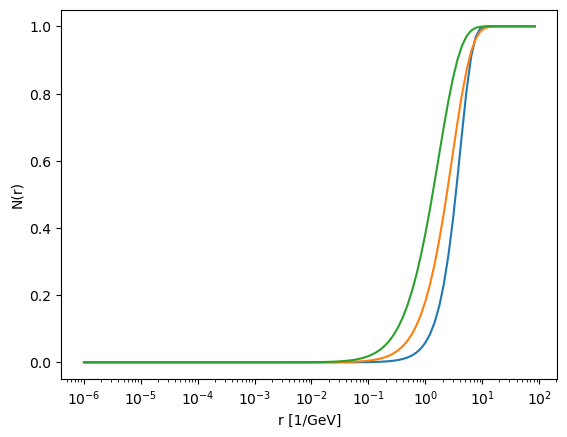

In [13]:
# interpolate unpolarized dipole for a given xBj

def get_N_interp(xBj):
    dipole = dipole_df[np.isclose(dipole_df['xBj'], xBj, atol=1e-7)]
    

    

x_grid, r_grid = np.mgrid[min(x_values):max(x_values):100j, min(r_values):max(r_values):100j]
exp_r_grid = np.exp(r_grid[0])

# Interpolate using 'cubic' method
N_inter = griddata((x_values, r_values), N_values, (x_grid, r_grid), method='cubic')

plt.plot(exp_r_grid, N_inter[0])
plt.plot(exp_r_grid, N_inter[50])
plt.plot(exp_r_grid, N_inter[-1])
plt.semilogx()
plt.xlabel('r [1/GeV]')
plt.ylabel('N(r)')
plt.show()

In [198]:
# compute N^{(c,d)}_{(a,b)}

Lam = 1 # GeV

# define the double-Bessel-dipole (DBD) transform
def N_func(pT, Q, z, xBj, inds):
    ia, ib, ic, id = inds
    prefactor = ((pT/Lam)**ic)*(((Q*np.sqrt(z*(1-z)))/Lam)**id)

    # select N(r, x = xBj)
    dipole = dipole_df[np.isclose(dipole_df['xBj'], xBj, atol=1e-7)]

    # riemann sum for integral
    sum = 0
    d = 0.1
    for _, irow in dipole.iterrows():
        u = irow['ln(r)']
        sum += d*(np.exp(u*(2+ic+id)))*jv(ia, (pT/Lam)*np.exp(u))*kv(ib, (Q/Lam)*np.sqrt(z*(1-z))*np.exp(u))*irow['N[ln(r)]']
        # sum += d*(np.exp(u*(2+ic+id)))*jv(ia, (pT/Lam)*np.exp(u))*kv(ib, (Q/Lam)*np.sqrt(z*(1-z))*np.exp(u))

    return prefactor*sum


# calculate the sum for various pT 
Q = np.sqrt(10) # GeV 
z = 0.2
pT_values = np.linspace(1, 10, 100)

N_pT_x0 = []
N_pT_x1 = []
N_pT_x2 = []

N_pT11_x0 = []
N_pT01_x0 = []

for ipT in pT_values: 
    N_pT_x0.append(N_func(ipT, Q, z, 0.01, [0,0,0,0]))
    N_pT_x1.append(N_func(ipT, Q, z, 0.001, [0,0,0,0]))
    N_pT_x2.append(N_func(ipT, Q, z, 0.0001, [0,0,0,0]))

    # N_pT_x0.append(N_func(ipT, Q, z, 0.01, [0,0,0,0]))


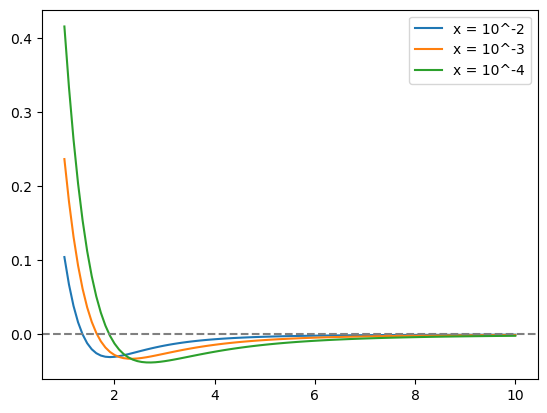

In [214]:
plt.plot(pT_values, N_pT_x0, label = "x = 10^-2")
plt.plot(pT_values, N_pT_x1, label = "x = 10^-3")
plt.plot(pT_values, N_pT_x2, label = "x = 10^-4")
plt.legend()
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
plt.show()

In [171]:
np.logspace(-2, -6, 1 + 36*1)

array([1.00000000e-02, 7.74263683e-03, 5.99484250e-03, 4.64158883e-03,
       3.59381366e-03, 2.78255940e-03, 2.15443469e-03, 1.66810054e-03,
       1.29154967e-03, 1.00000000e-03, 7.74263683e-04, 5.99484250e-04,
       4.64158883e-04, 3.59381366e-04, 2.78255940e-04, 2.15443469e-04,
       1.66810054e-04, 1.29154967e-04, 1.00000000e-04, 7.74263683e-05,
       5.99484250e-05, 4.64158883e-05, 3.59381366e-05, 2.78255940e-05,
       2.15443469e-05, 1.66810054e-05, 1.29154967e-05, 1.00000000e-05,
       7.74263683e-06, 5.99484250e-06, 4.64158883e-06, 3.59381366e-06,
       2.78255940e-06, 2.15443469e-06, 1.66810054e-06, 1.29154967e-06,
       1.00000000e-06])